In [1]:
from paddleocr import PaddleOCR,check_img
from paddleocr.tools.infer.utility import get_rotate_crop_image, get_minarea_rect_crop
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2

detector = PaddleOCR( use_angle_cls=False)
def text_detector(detector,img):
    ori_im = img.copy()
    dt_boxes = detector.ocr(img,det=True,rec=False,cls=False)
    if dt_boxes is None:
        return None, None
    return dt_boxes

PLEASE USE OMP_NUM_THREADS WISELY.


[2023/11/25 10:44:33] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\THETRUNG/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\THETRUNG/.paddleocr/whl\\det\\ch\\ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_scor

In [2]:
# def RotateRadian(angle_rad,crop):
#     #crop have shape(300,300)
#     angle_degree = angle_rad*180/np.pi
#     M = cv2.getRotationMatrix2D((150, 150), angle_degree, 1.0)
#     return cv2.warpAffine(crop, M, (300, 300))
def RotateRadian(angle_rad,size,crop):
    #crop have shape(300,300)
    angle_degree = angle_rad*180/np.pi
    M = cv2.getRotationMatrix2D((size/2,size/2), angle_degree, 1.0)
    return cv2.warpAffine(crop, M, (size, size))

In [113]:
def get_Loss(rotated_img):
    check_Region = rotated_img[100:200,100:200] 
    gray = cv2.GaussianBlur(check_Region ,(9,9),0)
    L2 = np.mean(np.mean(255-gray,axis=1)*(np.arange(110,190)-150)**2)
    return L2

In [4]:
def RotateImage(angle_in_rad):
    M = np.array(((np.cos(angle_in_rad), -np.sin(angle_in_rad)),
                  (np.sin(angle_in_rad), np.cos(angle_in_rad))))
    return M
RotateImage(np.pi/2).shape

(2, 2)

In [5]:
def show_images(img_list,name_list = None, max_column = 5,cmap = None):
    if len(img_list) == 0:
        return
    else:
        try:
            n = len(img_list)
            row = n // max_column + 1
            fig,a =  plt.subplots(row,max_column)
            if name_list == None:
                for i in range(n):
                    row_plot = i // max_column
                    col_plot = i % max_column
                    a[row_plot][col_plot].imshow(img_list[i])
            else:
                for i in range(n):
                    row_plot = i // max_column
                    col_plot = i % max_column
                    a[row_plot][col_plot].imshow(img_list[i])
                    a[row_plot][col_plot].set_title(name_list[i])
            if isinstance(cmap,None):
                plt.imshow()
            else:
                plt.imshow(cmap=cmap)
        except Exception as e:
            print(e)

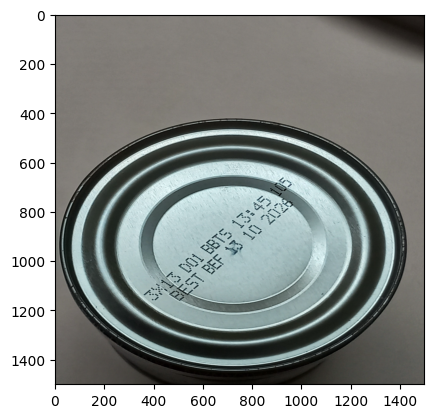

In [79]:
import cv2
img = cv2.imread('img2.jpg')
img = cv2.resize(img,(1500,1500))
# (h, w) = img.shape[:2]
# (cX, cY) = (w // 2, h // 2)
# M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
# img = cv2.warpAffine(img, M, (w, h))
plt.imshow(img)

(3590, 1, 2)


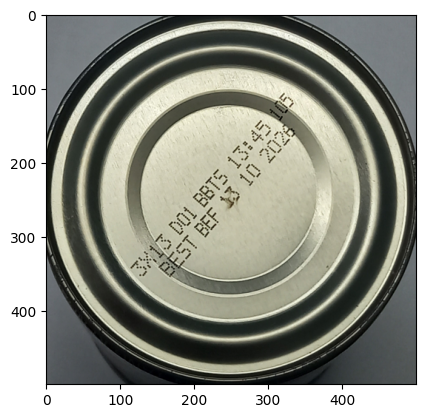

In [88]:
imgHSV=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
h_min = 14
h_max = 40
s_min = 10
s_max = 255
v_min = 50
v_max = 255
lower= np.array([h_min,s_min,v_min])
upper= np.array([h_max,s_max,v_max])
mask = cv2.inRange(imgHSV,lower,upper)
kernel = np.ones((8, 8), np.uint8)
mask_erosion = cv2.erode(mask, kernel, iterations=2)
new_mask = cv2.dilate(mask_erosion, kernel, iterations=8)
imgResult = cv2.bitwise_and(imgHSV,imgHSV,mask = new_mask)

# diagnoise

blur = cv2.GaussianBlur(new_mask ,(5,5),0)
edged = cv2.Canny(blur, 0, 50)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
total_cnt = []
for cnt in contours:
    if cv2.arcLength(cnt, True)>100:
        total_cnt.append(cnt)
        print(cnt.shape)
total_cnt = np.concatenate(total_cnt,axis = 0)
box = cv2.boundingRect(total_cnt)
cv2.rectangle(edged,box,color=(255))
x,y,w,h = box
cropImg = img[y:y+h,x:x+w]
cropImg = cv2.resize(cropImg,(500,500))
cropImg  = cv2.cvtColor(cropImg ,cv2.COLOR_BGR2RGB)
plt.imshow(cropImg)

[245 243]
194


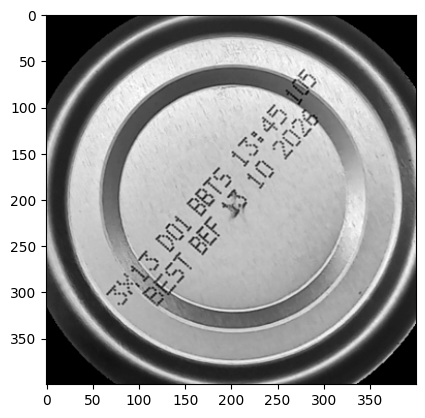

In [107]:
def GetCenter(imgO):
    img = imgO.copy()
    filter = np.zeros_like(img[:,:,0])
    m,n = filter.shape
    c = int(m/2)
    filter = cv2.circle(filter, (c,c), int(0.9*c), (255),-1)
    img_g = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,th =  cv2.threshold(img_g,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    bit_wise0 = np.where(filter==255,th,255 )
    
    circles = cv2.HoughCircles(bit_wise0,cv2.HOUGH_GRADIENT,1.2,100,
                            param1=300,param2=60,minRadius=int(0.3*c),maxRadius=int(0.9*c))
    circles = np.uint16(np.around(circles))[0,:]
    circle_info= np.uint16(np.mean(circles,axis=0))
    radius = circle_info[-1]
    centerPoint = circle_info[:2]
    filter1 = cv2.circle(filter, centerPoint, radius, (255),-1)
    output = np.where(filter1==255,img_g,0)
    output = output[centerPoint[1]-radius:centerPoint[1]+radius,
                    centerPoint[0]-radius:centerPoint[0]+radius]
    output = cv2.resize(output,(400,400))
    print(centerPoint)
    print(radius)
    # centerPoint = circles[]
    for i in circles:
        # draw the outer circle
        cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
    return img,output

out_img,final_crop = GetCenter(cropImg)
plt.imshow(out_img,cmap='gray')
plt.imshow(final_crop,cmap='gray')

7


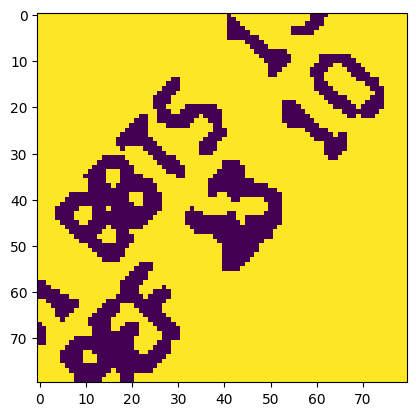

In [108]:
Resize_crop = cv2.resize(final_crop,(300,300))
check_Region = Resize_crop[110:190,110:190]
# gray = cv2.cvtColor(check_Region,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(check_Region ,(5,5),0)
kernel = np.ones((3, 3), np.uint8)
ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# th = cv2.erode(th, kernel, iterations=1)
lines = cv2.HoughLinesP(th, 1, np.pi/180, 10, minLineLength=50, maxLineGap=2)
print(len(lines))
draw = check_Region.copy()
theta_arr = np.array([0])
for line in lines:
    for x1, y1, x2, y2 in line:
        draw = cv2.line(draw, (x1, y1), (x2, y2), (0, 0, 255), 2)
        theta = np.arctan2(y2-y1,x2-x1)
        checker = theta_arr-theta
        if np.min(np.abs(checker)) < 0.12:
            continue
        else:
            theta_arr = np.append(theta_arr,theta)
        
plt.imshow(th)

In [109]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

(400, 400)
isinstance() arg 2 must be a type or tuple of types


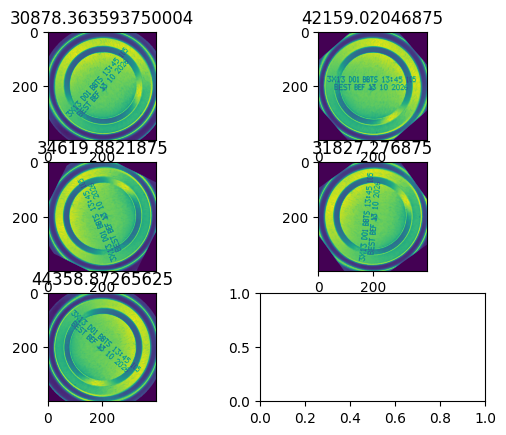

In [114]:

test_rot = []
name =[]
min_loss = 0
result = 0
for theta in theta_arr:
    rotated = RotateRadian(theta,400,final_crop) 
    loss = get_Loss(rotated)
    if min_loss == 0:
        min_loss = loss
        result = theta
    if loss < min_loss:
        min_loss == loss
        result = theta
    
    test_rot.append(rotated)
    name.append(str(loss))
print(test_rot[0].shape)
show_images(test_rot,name,max_column=2)




In [8]:
from my_tools.detector import First_progress
tool = First_progress()

[2023/11/25 10:44:51] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\THETRUNG/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\THETRUNG/.paddleocr/whl\\det\\ch\\ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_scor

In [24]:
a,b = tool.RotateCrop(cropImg)

(300, 300, 3)


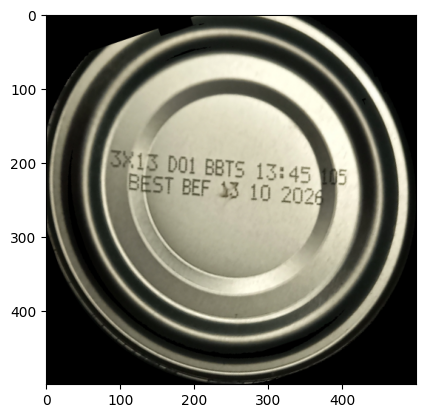

In [25]:
plt.imshow(b)

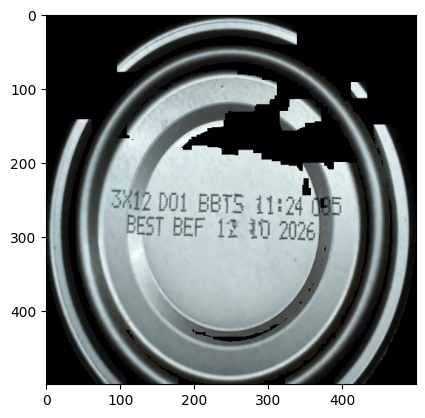

In [28]:
plt.imshow(cropImg)

[2023/11/25 10:51:56] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\THETRUNG/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\THETRUNG/.paddleocr/whl\\det\\ch\\ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_scor

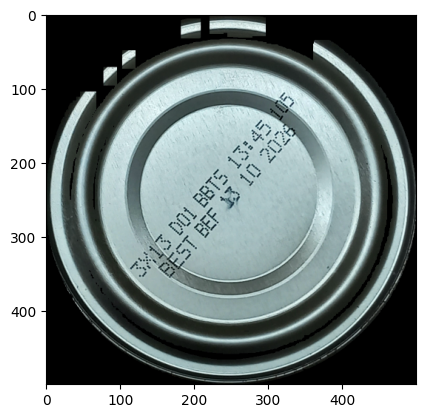

In [31]:
from my_tools.detector import First_progress

tool = First_progress()
img = cv2.imread('img2.jpg')
imgHSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
box,cropImg =  tool.get_Can_Region(imgHSV)
# angle, rotated = tool.RotateCrop(cropImg)
# rotated = cv2.cvtColor(rotated,cv2.COLOR_BGR2RGB)
# plt.imshow(rotated)
plt.imshow(cropImg)

shape: (500, 500, 3)
0.2739994525909424
[[141. 358.]
 [163. 363.]
 [136. 383.]
 [158. 387.]]
22 25
[[153. 325.]
 [178. 317.]
 [163. 356.]
 [187. 349.]]
26 32
[[178. 272.]
 [206. 281.]
 [162. 317.]
 [190. 327.]]
29 47
[[206. 260.]
 [238. 264.]
 [200. 310.]
 [232. 314.]]
32 50
[[223. 225.]
 [255. 227.]
 [220. 266.]
 [252. 268.]]
32 41
[[246. 184.]
 [275. 193.]
 [234. 224.]
 [263. 233.]]
30 41
[[267. 124.]
 [302. 135.]
 [248. 186.]
 [283. 197.]]
36 64
0.27700042724609375
isinstance() arg 2 must be a type or tuple of types


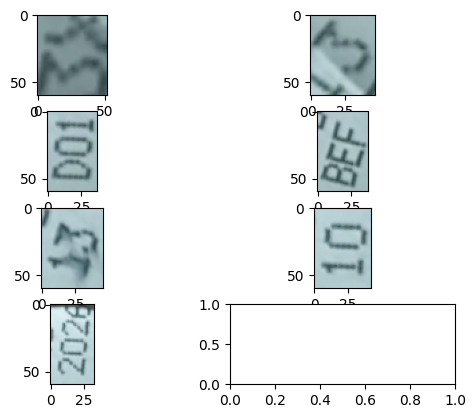

In [14]:
import time
start = time.time()
boxes = text_detector(detector,cropImg)
print(time.time()-start)
container = []
for box in boxes[0]:
    p1 = np.array(box[0])
    p2 = np.array(box[1])
    p3 = np.array(box[3])
    p4 = np.array(box[2])
    h = int(np.sqrt(np.sum(np.power(p3-p1,2))))
    w = int(np.sqrt(np.sum(np.power(p2-p1,2))))
    height = 60
    width = int(60*w/h)
    pts1 = np.float32([p1,p2,p3,p4])
    print(pts1)
    pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(cropImg, matrix, (width , height))
    container.append(result)
    print(w, h)
print(time.time()-start)
show_images(container,max_column=2)


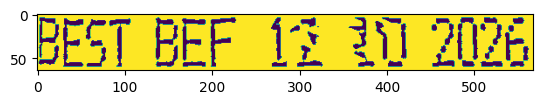

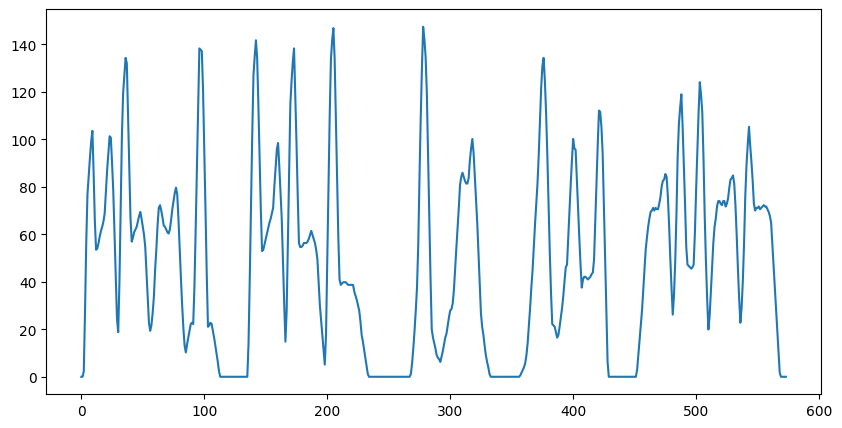

In [214]:
plt.imshow(container[1])
line = container[0]
gray_c = cv2.cvtColor(line,cv2.COLOR_BGR2GRAY)

thresh2 = cv2.adaptiveThreshold(gray_c, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 19, 11) 
thresh2[0:2,:] = 255
thresh2[-2:,:] = 255
thresh2 = np.pad(thresh2,2,constant_values=255)
region = 255-np.mean(thresh2,axis=0)
plt.imshow(thresh2)
plt.figure(figsize= [10,5])
# plt.plot(region)
filter = np.ones(7)/7
# plt.plot(np.diff(region))
plt.plot(np.convolve(filter,region))


In [215]:
def get_new_region(posA,posB):
    print(posA.shape)
    print(posB.shape)
    xA,yA = posA
    xB,yB = posB
    return np.array([min(xA,xB),max(yA,yB)])

In [216]:
posA = np.array([4,8])
posB = np.array([6,9])
get_new_region(posA,posB)

(2,)
(2,)


array([4, 9])

22
22
(2,)
(2,)
(2,)
(2,)
isinstance() arg 2 must be a type or tuple of types


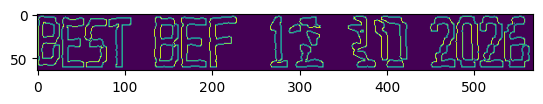

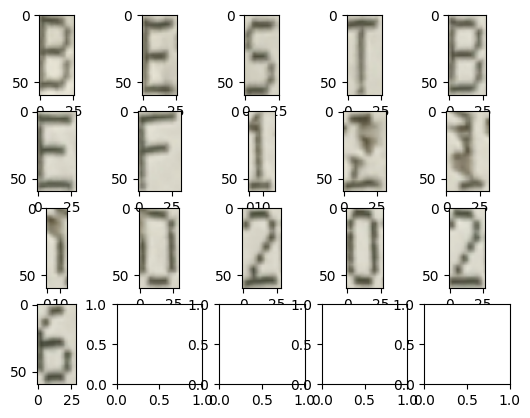

In [217]:
from operator import itemgetter
kernel = np.ones((3,3))
thresh_eroded = cv2.erode(thresh2, kernel, iterations=1)
blur = cv2.GaussianBlur(thresh_eroded ,(3,3),0)
edged = cv2.Canny(blur, 100, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(thresh_eroded)
plt.imshow(edged)
draw = np.zeros_like(edged)
mean_pos_x = np.array(sorted([np.mean(cnt,axis=0)[:,0] for cnt in contours]))

print(len(mean_pos_x))
print(len(np.diff(mean_pos_x)))
list_pos = np.array([[0,0]])
list_cnt = []
text =[]
count = 0
for cnt in contours:
    box = cv2.boundingRect(cnt)
    x,y,w,h= box
    if (w*h>250):
        count +=1
        cv2.rectangle(draw,box,color=(255))
        pos = np.array([x,x+w])
        center = x + w/2
        checker = list_pos - center 
        checker = (checker[:,0]*checker[:,1])<0    
        if checker.any()==True:
            idx = np.where(checker==True)[0][0]
            list_pos[idx] = get_new_region(list_pos[idx],pos)
        else:
            list_pos = np.vstack([list_pos,pos])
list_pos = np.sort(list_pos,axis=0)
for pos in list_pos[1:]:
    start = pos[0]
    stop = pos[1]
    text.append(line[:,start:stop,:])
show_images(text)
        # list_pos.append(pos)
# plt.imshow(draw)
# print(len(list_pos[1:]))
# print(count)

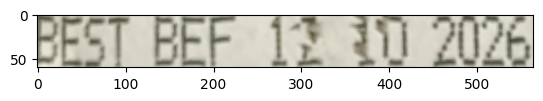

In [218]:
plt.imshow(line)

[[1, 24], [29, 52], [55, 78], [82, 106], [135, 160], [165, 192], [198, 227], [267, 285], [289, 326], [356, 422], [451, 477], [480, 504], [507, 532], [535, 562]]
isinstance() arg 2 must be a type or tuple of types


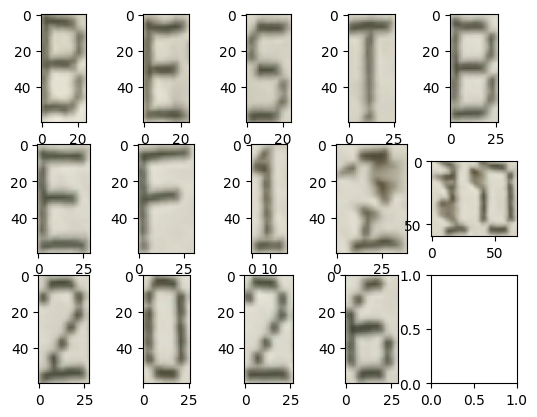

In [219]:
change = np.diff(region>0)
pos = []
list_pos = []
for idx,value in enumerate(change):
    if len(pos) == 2:
        list_pos.append(pos)
        pos = []
    else:
        if value == 1:
            pos.append(idx)
print(list_pos)
text = []
for pos in list_pos:
    start = pos[0]-1
    stop = pos[1]+1
    # if stop-start <40:
    text.append(line[:,start:stop])
    # else:
    #     n = (stop-start)/27
    #     wi = (stop - start)/int(n)
    #     pre_point = start
    #     for i in range(int(n)):
    #         text.append(line[:,pre_point:pre_point+int(wi)])
    #         pre_point += int(wi)
show_images(text)

[[ 60 156]
 [ 62 105]
 [566 121]
 [564 172]]


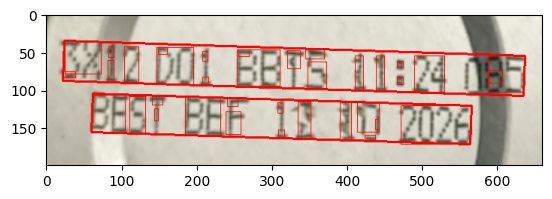

In [220]:

test = cropImg[220:320,80:410]
w_i = width/23
char_list = []
h,w,_ = test.shape
test = cv2.resize(test,[w*2,h*2])
gray_c = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)



ret,th = cv2.threshold(gray_c,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh2 = cv2.adaptiveThreshold(gray_c, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY,19, 11) 
kernel = np.ones((3, 3), np.uint8)
binary = cv2.erode(thresh2, kernel, iterations=1)
binary = cv2.medianBlur(binary,13)
binary = cv2.dilate(binary , kernel, iterations=1)

# plt.imshow(th)
lines = cv2.HoughLinesP(th, 1, np.pi/180, 15, minLineLength=200, maxLineGap=2)
blur = cv2.GaussianBlur(binary ,(3,3),0)
edged = cv2.Canny(blur, 100, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
draw = test.copy()
up_cnt = []
down_cnt =[]
for cnt in contours:
    if cv2.contourArea(cnt)>50:
        x,y,w,h = cv2.boundingRect(cnt)
        if y+h/2 <100:
            up_cnt.append(cnt)
        elif y+h/2 >100:
            down_cnt.append(cnt)
        cv2.rectangle(draw,[x,y,w,h],color=(255))
up_cnt = np.vstack(up_cnt)
down_cnt = np.vstack(down_cnt)
rect_u = cv2.minAreaRect(up_cnt)
rect_d = cv2.minAreaRect(down_cnt)
boxes = []
for cnt in [up_cnt,down_cnt]:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    boxes.append(box)
    cv2.drawContours(draw,[box],0,(255),2)


plt.imshow(draw)
# show_images(char_list)
print(box)

[[ 18.  29.]
 [643.  49.]
 [ 16.  94.]
 [641. 114.]]
[[ 56.  99.]
 [572. 115.]
 [ 54. 162.]
 [570. 178.]]
isinstance() arg 2 must be a type or tuple of types


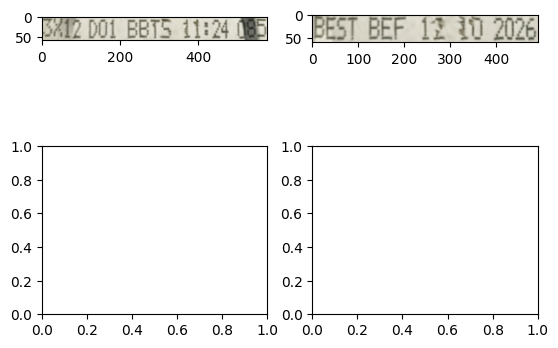

In [221]:

container = []
pad = 6
for point in boxes:
    p1 = np.array([point[1][0]-pad,point[1][1]-pad])
    p2 = np.array([point[2][0]+pad,point[2][1]-pad])
    p3 = np.array([point[0][0]-pad,point[0][1]+pad])
    p4 = np.array([point[3][0]+pad,point[3][1]+pad])
    h = int(np.sqrt(np.sum(np.power(p3-p1,2))))
    w = int(np.sqrt(np.sum(np.power(p2-p1,2))))
    height = 60
    width = int(60*w/h)
    pts1 = np.float32([p1,p2,p3,p4])
    pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
    print(pts1)
    matrix = cv2.getPerspectiveTransform(np.array(pts1), pts2)
    result = cv2.warpPerspective(test, matrix, (width , height))
    container.append(result)
show_images(container,max_column=2)

isinstance() arg 2 must be a type or tuple of types


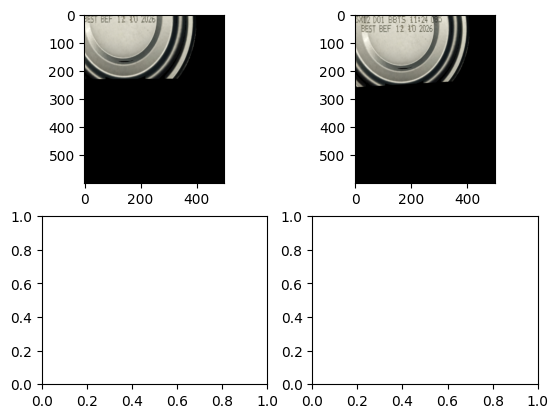

In [14]:
show_images(container,max_column=2)

In [271]:
print(theta_arr)

[ 0.         -0.14756807]


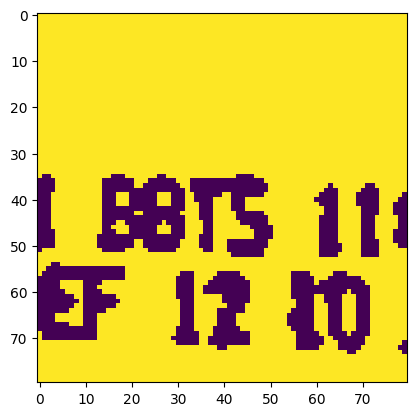

In [262]:
plt.imshow(th)

In [7]:
from tools.detector import First_progress
task1 = First_progress()
img = cv2.imread('img2.jpg')
imgHSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
box,crop =  task1.get_Can_Region(imgHSV)

ModuleNotFoundError: No module named 'tools.detector'

In [ ]:
crop.shape

(300, 300, 3)

In [ ]:
print(crop.shape)

: 

In [ ]:
print(hierarchy)

[[[ 1 -1 -1 -1]
  [-1  0 -1 -1]]]


In [ ]:

img = check_img(img)
detectbox = text_detector(detector,img)
detectbox 

shape: (2560, 1920, 3)
shape: (2560, 1920, 3)


[[[[445.0, 1915.0], [548.0, 1843.0], [609.0, 1927.0], [505.0, 1999.0]],
  [[581.0, 1784.0], [663.0, 1774.0], [676.0, 1872.0], [594.0, 1882.0]],
  [[1012.0, 1248.0], [1137.0, 1248.0], [1137.0, 1371.0], [1012.0, 1371.0]],
  [[1162.0, 1136.0], [1227.0, 1136.0], [1227.0, 1195.0], [1162.0, 1195.0]]]]

In [42]:
detectbox

[[[[803.0, 1600.0], [982.0, 1445.0], [1051.0, 1528.0], [871.0, 1683.0]]]]

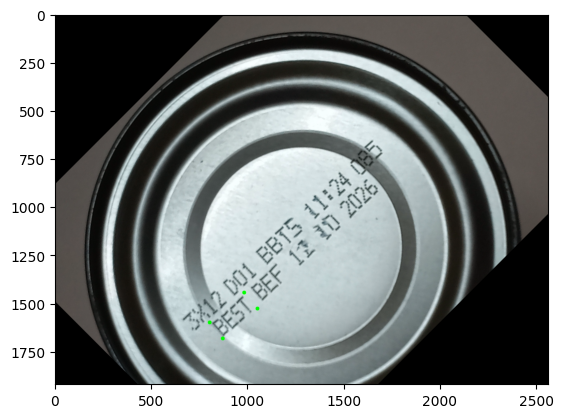

In [44]:

for point in detectbox[0][0]:
    cv2.circle(img, np.array(point).astype(int), radius=10, color=(0, 255, 0), thickness=-1)
plt.imshow(img)

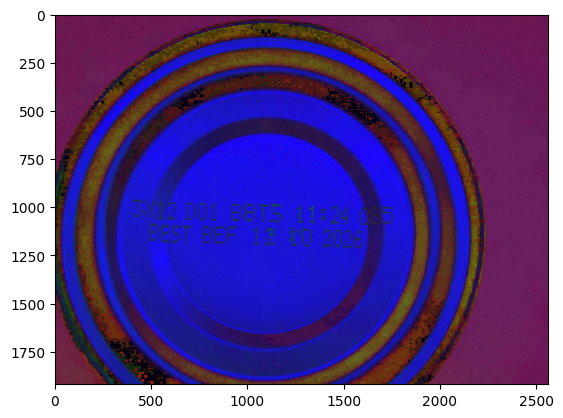

In [21]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('img1.jpg')
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

plt.imshow(hsv)